##### LIBRARIES

In [1]:
# Necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

##### QUESTION 1

In [2]:
# Step 1: Define DJIA Stocks and Fetch Data
djia_stocks = [
    'MMM', 'AMZN', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 
    'GS', 'HD', 'HON', 'IBM', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 
    'NVDA', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WMT', 'DIS', 'WBA'
]

# Fetch daily adjusted close prices
data = yf.download(djia_stocks, start="2020-01-01", end="2024-01-01")['Adj Close']

# Step 2: Calculate Daily Returns
returns = data.pct_change().dropna()

[*********************100%***********************]  30 of 30 completed


Ticker      AAPL      AMGN      AMZN       AXP        BA       CAT       CRM  \
Ticker                                                                         
AAPL    1.000000  0.429031  0.624233  0.480295  0.428785  0.373033  0.587360   
AMGN    0.429031  1.000000  0.289901  0.332053  0.215571  0.369644  0.294562   
AMZN    0.624233  0.289901  1.000000  0.308003  0.279849  0.227287  0.588605   
AXP     0.480295  0.332053  0.308003  1.000000  0.660620  0.616131  0.403958   
BA      0.428785  0.215571  0.279849  0.660620  1.000000  0.512500  0.353374   
CAT     0.373033  0.369644  0.227287  0.616131  0.512500  1.000000  0.294478   
CRM     0.587360  0.294562  0.588605  0.403958  0.353374  0.294478  1.000000   
CSCO    0.582054  0.477985  0.399509  0.523710  0.407943  0.484583  0.447856   
CVX     0.360438  0.318727  0.164627  0.634249  0.553024  0.618444  0.290511   
DIS     0.485670  0.287400  0.435984  0.658260  0.557017  0.523576  0.450855   
GS      0.507708  0.374097  0.356061  0.

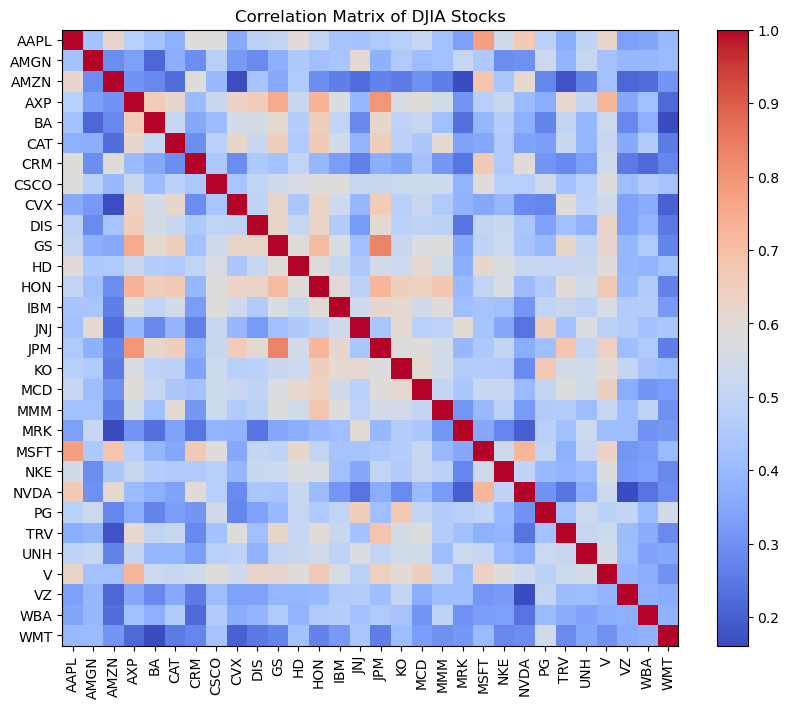

In [3]:
# Step 3: Correlation Matrix
covariance_matrix = returns.cov()
correlation_matrix = covariance_matrix / np.outer(returns.std(), returns.std())
np.fill_diagonal(correlation_matrix.values, 1)  # Ensure diagonal values are 1
print(correlation_matrix)

#plot the correlation matrix as a heatmap and ensure it has the values of the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar() # use sns lib
plt.title('Correlation Matrix of DJIA Stocks')
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()

In [4]:
# Step 4: Perform PCA
scaler = StandardScaler()
scaled_correlation_matrix = scaler.fit_transform(correlation_matrix)

In [5]:
# Apply PCA
pca = PCA()
pca.fit(scaled_correlation_matrix)

# Extract principal components
pc1 = pca.components_[0]  # First principal component
pc2 = pca.components_[1]  # Second principal component

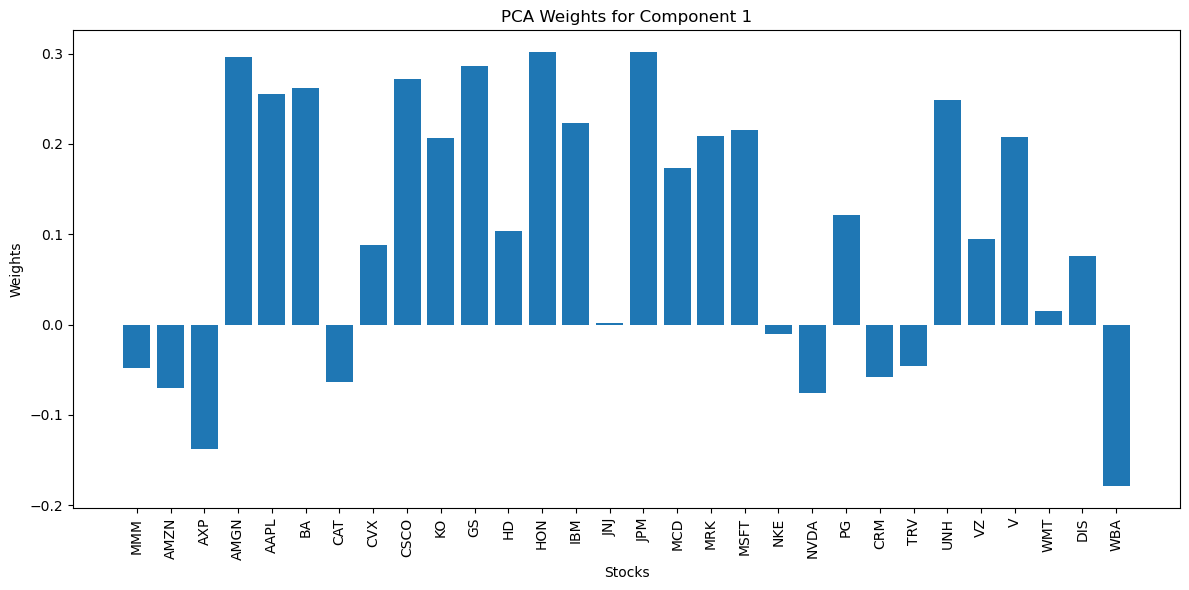

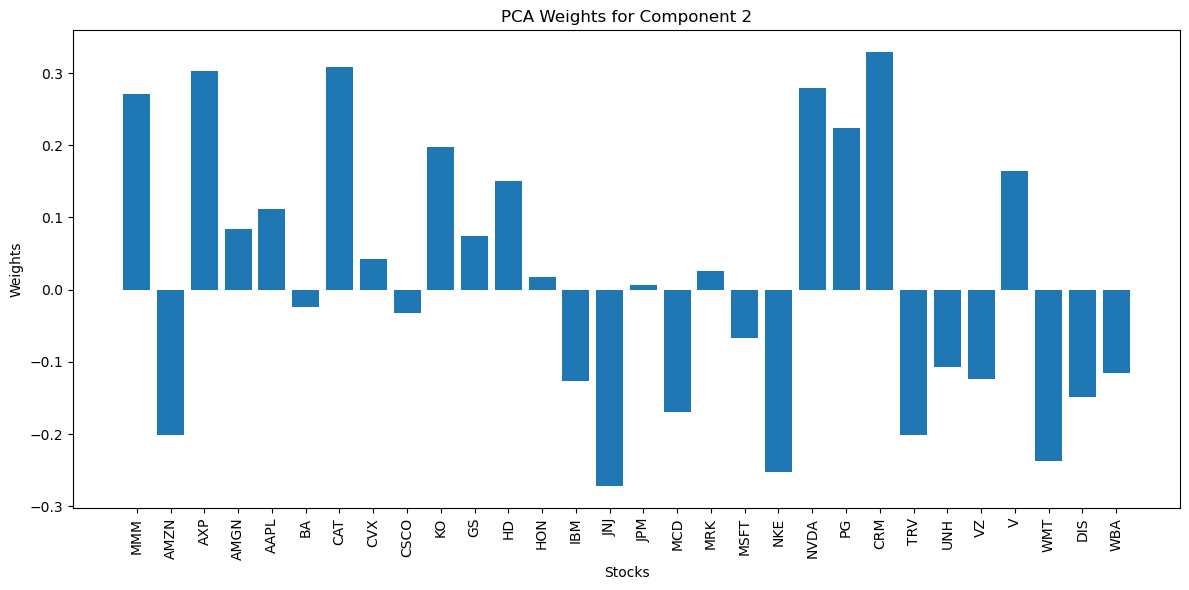

In [6]:
# Step 5: Bar Graphs for PC1 and PC2
def plot_component(c_weights, c_number):
    plt.figure(figsize=(12, 6))
    plt.bar(djia_stocks, c_weights)
    plt.title(f'PCA Weights for Component {c_number}')
    plt.xlabel("Stocks")
    plt.ylabel("Weights")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_component(pc1, 1)
plot_component(pc2, 2)

In [7]:
# Step 6: Similarity Calculation
equal_weight = np.ones(len(djia_stocks)) / len(djia_stocks)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

sim_pc1 = cosine_similarity(pc1, equal_weight)
sim_pc2 = cosine_similarity(pc2, equal_weight)

print(f"Similarity between PC1 and market: {sim_pc1:.4f}")
print(f"Similarity between PC2 and market: {sim_pc2:.4f}")

Similarity between PC1 and market: 0.5977
Similarity between PC2 and market: 0.0936


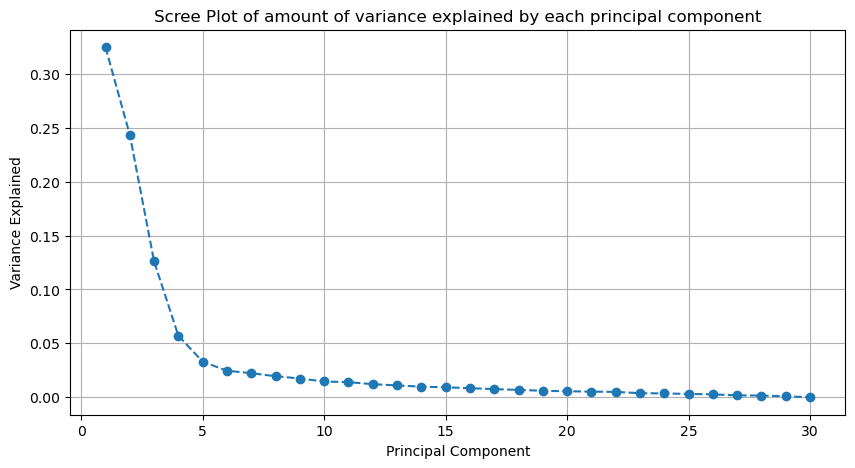

In [8]:
# Step 6: Scree Plot
# Calculate variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title("Scree Plot of amount of variance explained by each principal component")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid()
plt.show()

In [9]:
# Step 7: Calculate Cumulative Variance
# Determine the number of components to explain 95% variance
cumulative_variance = np.cumsum(explained_variance_ratio)
components_required = np.argmax(cumulative_variance >= 0.95) + 1  # +1 because index starts at 0
print(f"Number of principal components required to explain 95% of the variance: {components_required}")

Number of principal components required to explain 95% of the variance: 17


c:\Users\STUDENT\anaconda3\envs\myenv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


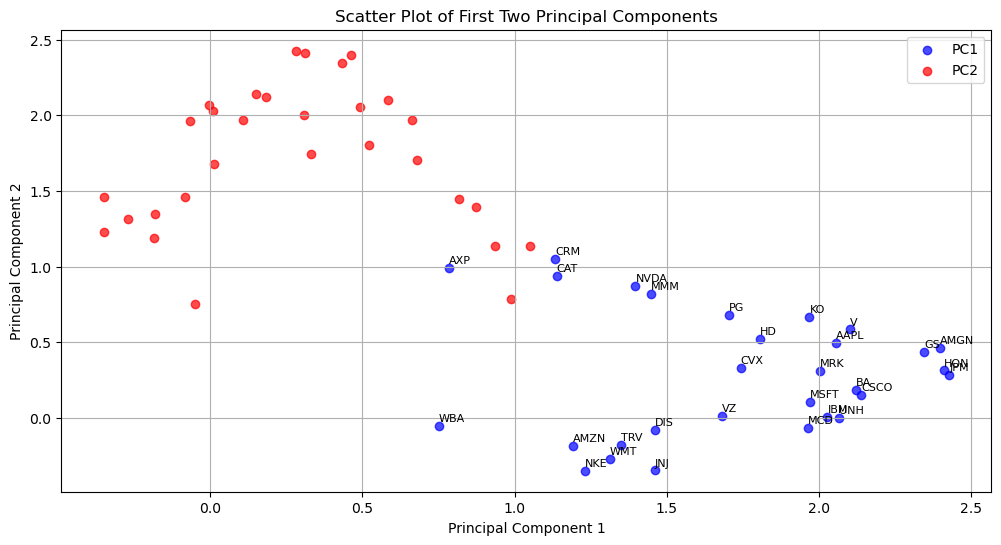

In [10]:
# Step 8: Scatter Plot of the First Two Principal Components
# Project the returns data onto the first two principal components
principal_components = pca.transform(correlation_matrix)
pc1_scores = principal_components[:, 0]
pc2_scores = principal_components[:, 1]

offset = 0.03
# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(pc1_scores, pc2_scores, alpha=0.7, label='PC1', color='blue')
plt.scatter(pc2_scores, pc1_scores, alpha=0.7, label='PC2', color='red')
# create loop to add the stock names to the scatter plot
for i, stock in enumerate(djia_stocks):
    plt.text(pc1_scores[i], pc2_scores[i] + offset, stock, fontsize=8)
plt.title("Scatter Plot of First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid()
plt.show()

In [11]:
# calculate mean for 30 stocks for both pc1 and pc2
mean_pc1 = np.mean(pc1)
mean_pc2 = np.mean(pc2)
print(f"Mean of PC1: {mean_pc1}")
print(f"Mean of PC2: {mean_pc2}")

# calculate euclidean distances from mean
euclidean_distances = np.sqrt((pc1 - mean_pc1)**2 + (pc2 - mean_pc2)**2)

# combine the stocks and their euclidean distances
stocks_distances = pd.DataFrame({'Stocks': djia_stocks, 'Distances': euclidean_distances})

# sort the stocks by their euclidean distances
stocks_distances = stocks_distances.sort_values(by='Distances', ascending=False)

# 3 most distant stocks
most_distant_stocks = stocks_distances.head(3)
for i, row in most_distant_stocks.iterrows():
    print(f"Stock: {row['Stocks']}, Distance: {row['Distances']}")

Mean of PC1: 0.10912675756834987
Mean of PC2: 0.017094392702133008
Stock: AXP, Distance: 0.3771353834414174
Stock: CRM, Distance: 0.35410399801627196
Stock: CAT, Distance: 0.338966554153936


##### Number 2

#####  PART 2.3

           MMM      AMZN       AXP      AMGN      AAPL        BA       CAT  \
MMM   0.000000  1.215803  0.956618  1.073848  1.068064  1.079872  0.890616   
AMZN  1.215803  0.000000  1.176432  1.191720  0.866910  1.200126  1.243152   
AXP   0.956618  1.176432  0.000000  1.155808  1.019514  0.823869  0.876206   
AMGN  1.073848  1.191720  1.155808  0.000000  1.068615  1.252541  1.122814   
AAPL  1.068064  0.866910  1.019514  1.068615  0.000000  1.068845  1.119792   
BA    1.079872  1.200126  0.823869  1.252541  1.068845  0.000000  0.987421   
CAT   0.890616  1.243152  0.876206  1.122814  1.119792  0.987421  0.000000   
CVX   1.040929  1.292573  0.855279  1.167281  1.130984  0.945491  0.873563   
CSCO  0.966963  1.095893  0.976002  1.021778  0.914271  1.088170  1.015300   
KO    0.951077  1.220998  0.931608  1.044966  1.025271  1.009383  1.016281   
GS    0.915885  1.134847  0.702928  1.118841  0.992263  0.887980  0.838759   
HD    0.955746  1.043643  0.972296  1.047466  0.899109  1.030660

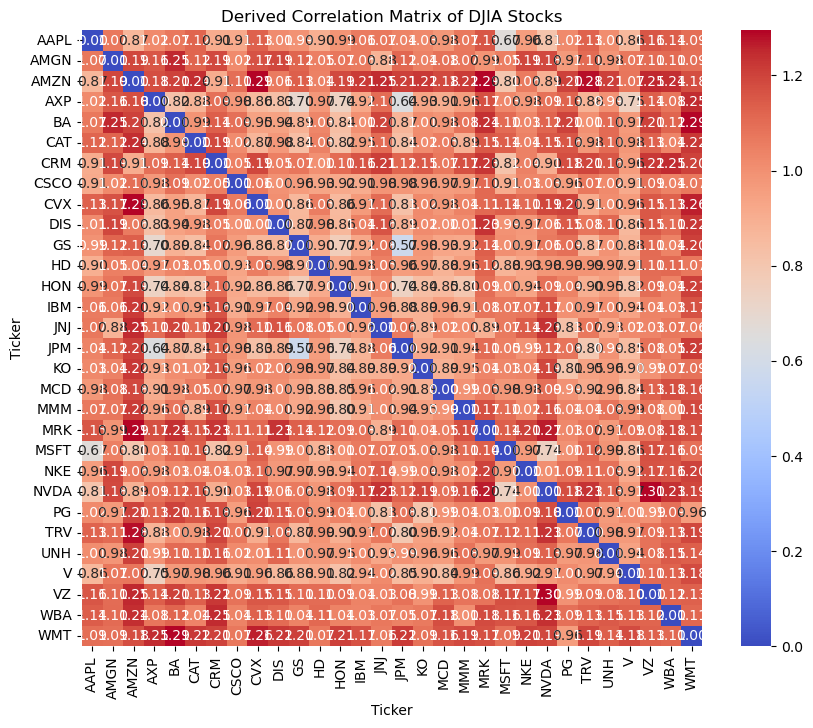

In [12]:
# derived correlation matrix is the correlation matrix of the two stocks

pairwise_distances = np.sqrt(2 * (1 - correlation_matrix))

#display the derived correlation matrix as a dataframe
print(pd.DataFrame(pairwise_distances, index=djia_stocks, columns=djia_stocks))

# display the derived correlation matrix as a heatmap using sns
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_distances, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Derived Correlation Matrix of DJIA Stocks')
plt.show()


##### PART 2.4 

[*********************100%***********************]  30 of 30 completed


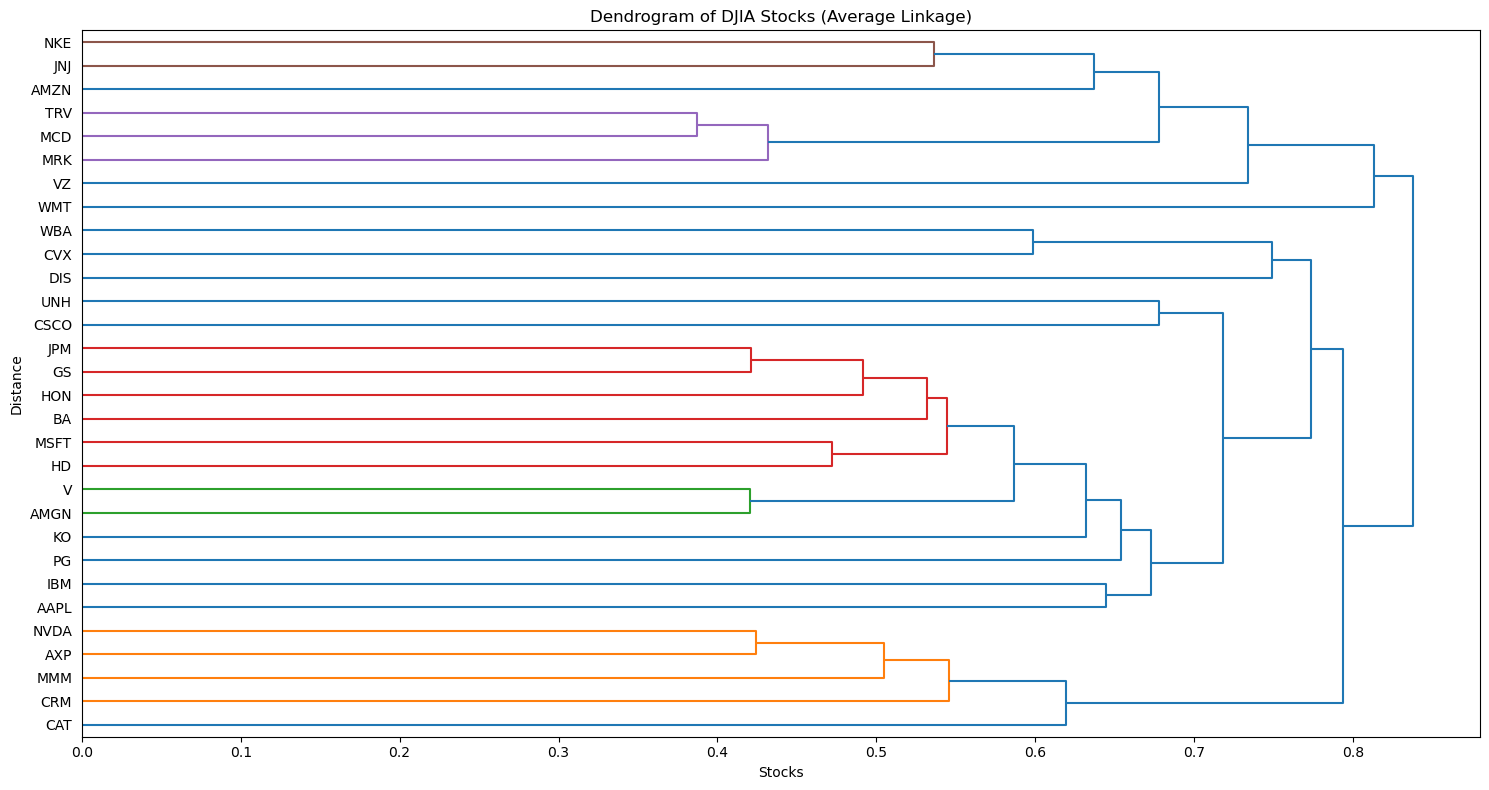

In [13]:
# List of DJIA stocks
djia_stocks = ['MMM', 'AMZN', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 
               'GS', 'HD', 'HON', 'IBM', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 
               'NVDA', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WMT', 'DIS', 'WBA']

# Fetch daily adjusted close prices for one year
data = yf.download(djia_stocks, start="2023-01-01", end="2024-01-01")['Adj Close']

# Calculate daily returns and correlation matrix
returns = data.pct_change().dropna()
correlation_matrix = returns.corr()

# Convert correlation to distance
distance_matrix = (1 - correlation_matrix)

# Convert the distance matrix into a condensed form for hierarchical clustering
condensed_distance = squareform(distance_matrix)

# Perform hierarchical clustering using average linkage
linkage_matrix = linkage(condensed_distance, method='average')

# Plot the horizontal dendrogram
plt.figure(figsize=(15, 8))
dendro = dendrogram(linkage_matrix, labels=djia_stocks, orientation='right')
plt.title("Dendrogram of DJIA Stocks (Average Linkage)")
plt.xlabel("Stocks")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

##### PART 2.5 

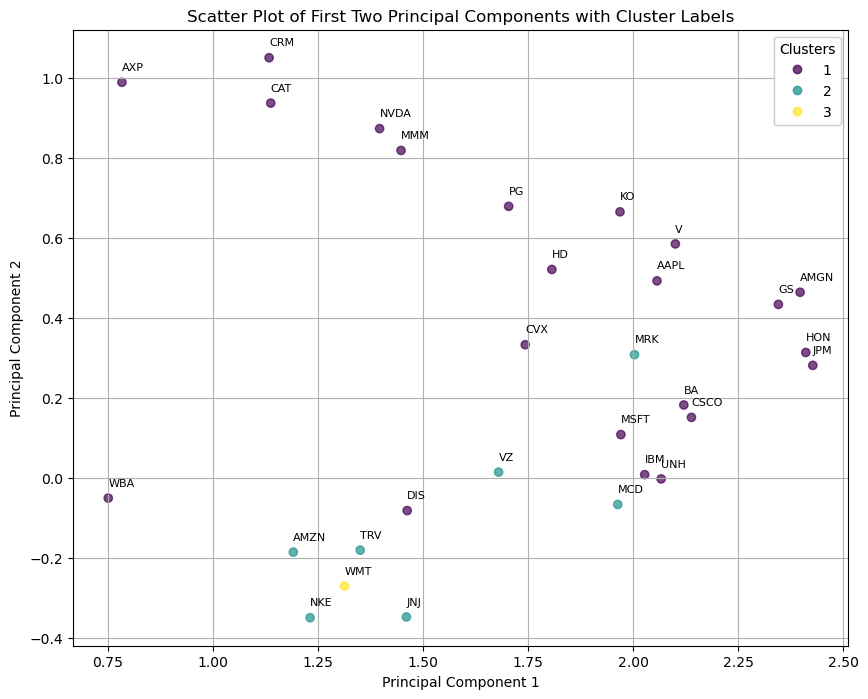

In [14]:
# scatter plot of pc1 and pc2 with cluster labels
# Assign cluster labels
cluster_labels = fcluster(linkage_matrix, 3, criterion='maxclust')

# Scatter plot of the first two principal components with cluster labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pc1_scores, pc2_scores, c=cluster_labels, cmap='viridis', alpha=0.7)
for i, stock in enumerate(djia_stocks):
    plt.text(pc1_scores[i], pc2_scores[i] + offset, stock, fontsize=8)
plt.title("Scatter Plot of First Two Principal Components with Cluster Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Create a legend with cluster labels
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)
plt.grid()
plt.show()

##### Number 3


In [15]:
#load the titanic dataset using pandas
titanic_data = pd.read_csv('titanic3.csv')

# Display the first few rows of the dataset
display(titanic_data.head())

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [16]:
# Handle missing values
titanic_data['age'].fillna(titanic_data['age'].median())
titanic_data['embarked'].fillna(titanic_data['embarked'].mode()[0])
titanic_data['fare'].fillna(titanic_data['fare'].median())


# Encode categorical variables
# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
titanic_data['sex'] = label_encoder.fit_transform(titanic_data['sex'])
titanic_data['embarked'] = label_encoder.fit_transform(titanic_data['embarked'])

# Preprocessing
# Select relevant features and target
X = titanic_data[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
y = titanic_data['survived']


In [17]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Print the sum of null values in the dataset for X_scaled
print(np.isnan(X_scaled))

# Find the optimal number of trees
num_trees = list(range(10, 501, 100)) 
accuracy_scores = []

for n in num_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_scaled, y)
    y_pred = rf.predict(X_scaled)
    accuracy_scores.append(accuracy_score(y, y_pred))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


##### PART 3.4

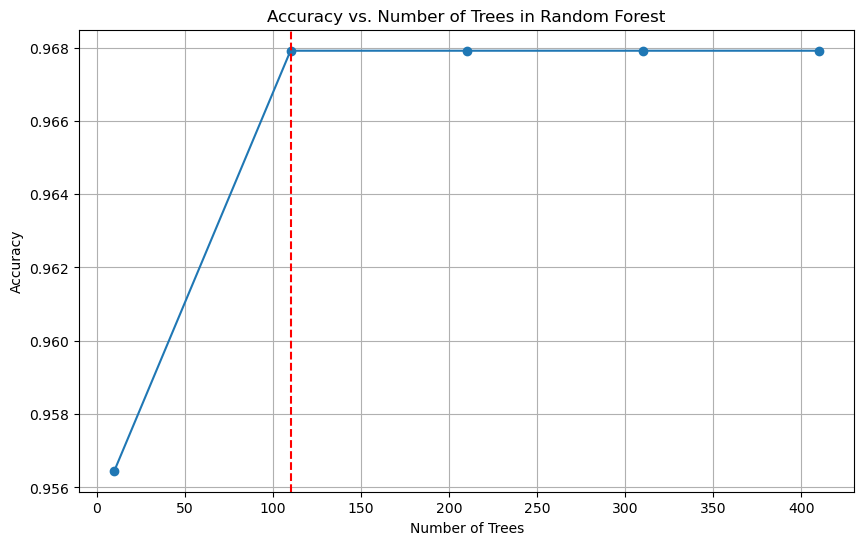

Optimal number of trees: 110
Final Model Accuracy: 0.967914


In [18]:
# Plot accuracy vs. number of trees
plt.figure(figsize=(10, 6))
plt.plot(num_trees, accuracy_scores, marker='o')
plt.title("Accuracy vs. Number of Trees in Random Forest")
plt.axvline(x=num_trees[np.argmax(accuracy_scores)], color='r', linestyle='--', label='Optimal Number of Trees')
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

# Use the optimal number of trees found earlier
optimal_trees = num_trees[np.argmax(accuracy_scores)]
print(f"Optimal number of trees: {optimal_trees}")

# Train the final Random Forest model with the optimal number of trees
final_rf = RandomForestClassifier(n_estimators=optimal_trees, random_state=42)
final_rf.fit(X_scaled, y)

# Evaluate the final model
y_pred = final_rf.predict(X_scaled)
final_accuracy = accuracy_score(y, y_pred)
print(f"Final Model Accuracy: {final_accuracy:.6f}")


In [19]:
#construct the final random forest model without splitting data
# Train the final Random Forest model with the optimal number of trees
final_rf = RandomForestClassifier(n_estimators=optimal_trees, random_state=42)
final_rf.fit(X_scaled, y)

# Evaluate the final model
y_pred = final_rf.predict(X_scaled)
final_accuracy = accuracy_score(y, y_pred)
print(f"Final Model Accuracy: {final_accuracy:.6f}")


Final Model Accuracy: 0.967914


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       809
           1       0.97      0.95      0.96       500

    accuracy                           0.97      1309
   macro avg       0.97      0.96      0.97      1309
weighted avg       0.97      0.97      0.97      1309



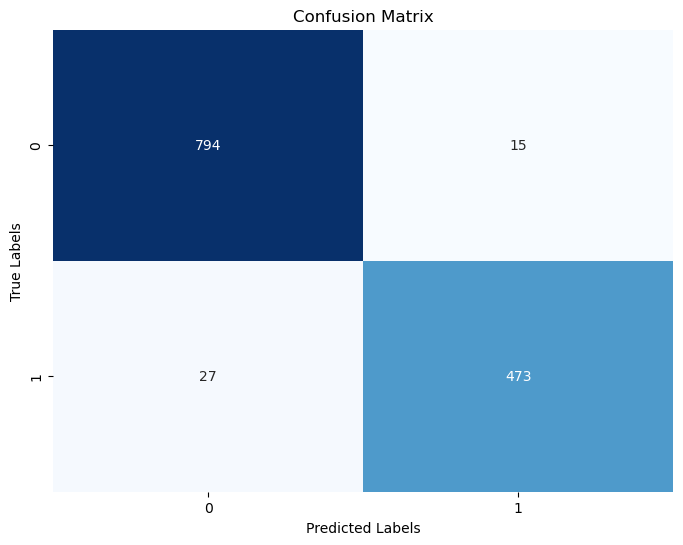

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       809
           1       0.97      0.95      0.96       500

    accuracy                           0.97      1309
   macro avg       0.97      0.96      0.97      1309
weighted avg       0.97      0.97      0.97      1309



In [20]:
#print the classification report
print(classification_report(y, y_pred))

#create a confusion matrix
conf_matrix = confusion_matrix(y, y_pred)

#plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

#classification report
print(classification_report(y, y_pred))


##### PART 3.5

Logistic Regression AUC: 0.843965
Decision Tree AUC: 0.997449
K-Nearest Neighbors AUC: 0.923884
Random Forest AUC: 0.977787


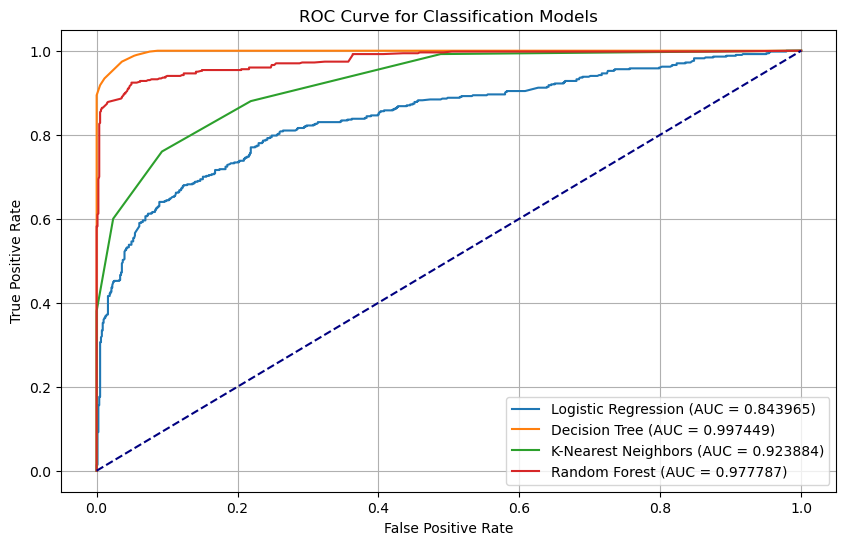

                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression  0.792208   0.744635   0.694  0.718427
1        Decision Tree  0.967914   0.981092   0.934  0.956967
2  K-Nearest Neighbors  0.851031   0.835165   0.760  0.795812


In [21]:
# training with other models, logistic regression, decision tree, and kneighbors
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_scaled)

# Initialize the models
log_reg = LogisticRegression(random_state=42)
dec_tree = DecisionTreeClassifier(random_state=42)
knn = KNeighborsClassifier()

# Train the models
log_reg.fit(X_imputed, y)
dec_tree.fit(X_imputed, y)
knn.fit(X_imputed, y)

# Predict on the training data
y_pred_log_reg = log_reg.predict(X_imputed)
y_pred_dec_tree = dec_tree.predict(X_imputed)
y_pred_knn = knn.predict(X_imputed)
y_pred_rf = final_rf.predict(X_imputed)

# performing the roc analysis and auc values
# Generate predicted probabilities
y_prob_log_reg = log_reg.predict_proba(X_imputed)[:, 1]
y_prob_dec_tree = dec_tree.predict_proba(X_imputed)[:, 1]
y_prob_knn = knn.predict_proba(X_imputed)[:, 1]
y_prob_rf = final_rf.predict_proba(X_imputed)[:, 1]

# Calculate the ROC curve for logistic regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y, y_prob_log_reg)
roc_auc_log_reg = roc_auc_score(y, y_prob_log_reg)

# Calculate the ROC curve for decision tree
fpr_dec_tree, tpr_dec_tree, _ = roc_curve(y, y_prob_dec_tree)
roc_auc_dec_tree = roc_auc_score(y, y_prob_dec_tree)

# Calculate the ROC curve for k-nearest neighbors
fpr_knn, tpr_knn, _ = roc_curve(y, y_prob_knn)
roc_auc_knn = roc_auc_score(y, y_prob_knn)

# Calculate the ROC curve for random forest
fpr_rf, tpr_rf, _ = roc_curve(y, y_prob_rf)
roc_auc_rf = roc_auc_score(y, y_prob_rf)


# Print the AUC scores
print(f"Logistic Regression AUC: {roc_auc_log_reg:.6f}")
print(f"Decision Tree AUC: {roc_auc_dec_tree:.6f}")
print(f"K-Nearest Neighbors AUC: {roc_auc_knn:.6f}")
print(f"Random Forest AUC: {roc_auc_rf:.6f}")

# Plot the ROC curve for each model
plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.6f})')
plt.plot(fpr_dec_tree, tpr_dec_tree, label=f'Decision Tree (AUC = {roc_auc_dec_tree:.6f})')
plt.plot(fpr_knn, tpr_knn, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn:.6f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.6f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("ROC Curve for Classification Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# use other metrics for evaluation
# Create a dictionary to store the evaluation metrics for each model
evaluation_metrics = {
    'Model': ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors'],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# List of predictions for each model
predictions = [y_pred_log_reg, y_pred_dec_tree, y_pred_knn]

# Calculate evaluation metrics for each model
for y_pred in predictions:
    evaluation_metrics['Accuracy'].append(accuracy_score(y, y_pred))
    evaluation_metrics['Precision'].append(precision_score(y, y_pred))
    evaluation_metrics['Recall'].append(recall_score(y, y_pred))
    evaluation_metrics['F1 Score'].append(f1_score(y, y_pred))

# Convert the evaluation metrics dictionary to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_metrics)

# Display the evaluation metrics
print(evaluation_df)

##### QUESTION 4

In [22]:
#load the red wine quality dataset using pandas
wine_data = pd.read_csv('winequality-red.csv', sep=';')

# Display the first few rows of the dataset
display(wine_data.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [23]:
#load the white wine quality dataset using pandas
wine_data_white = pd.read_csv('winequality-white.csv', sep=';')

# Display the first few rows of the dataset
display(wine_data_white.head())

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


##### PART 4.2

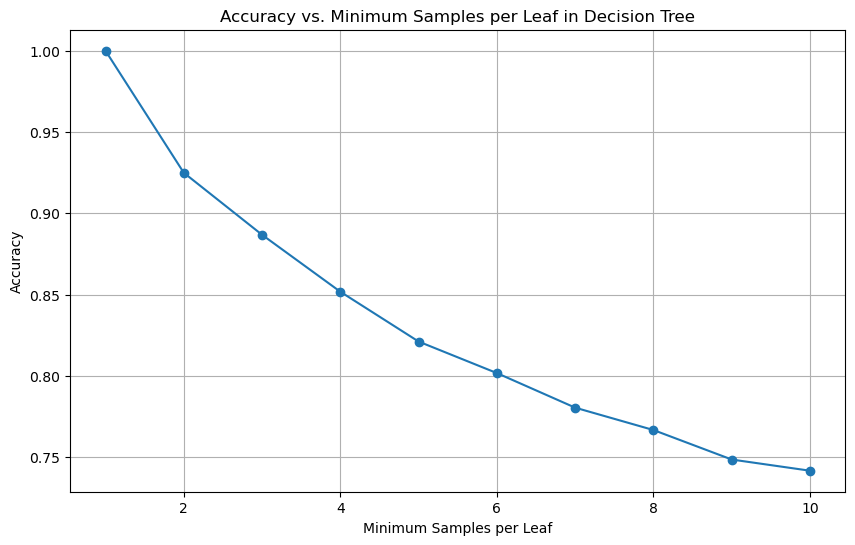

Minimum samples per leaf: 1, Accuracy: 1.0000
Minimum samples per leaf: 2, Accuracy: 0.9250
Minimum samples per leaf: 3, Accuracy: 0.8868
Minimum samples per leaf: 4, Accuracy: 0.8518
Minimum samples per leaf: 5, Accuracy: 0.8211
Minimum samples per leaf: 6, Accuracy: 0.8018
Minimum samples per leaf: 7, Accuracy: 0.7805
Minimum samples per leaf: 8, Accuracy: 0.7667
Minimum samples per leaf: 9, Accuracy: 0.7486
Minimum samples per leaf: 10, Accuracy: 0.7417
Optimal minimum samples per leaf: 1


In [24]:
# Step 1: Load and preprocess the dataset
wine_data = pd.read_csv('winequality-red.csv', sep=';')

#separate the features and target
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# list of different minimum samples per leaf to try like in this code (num_trees = list(range(10, 501, 100)))
# List of minimum samples per leaf to try
min_samples_leaf = list(range(1, 11))
accuracy_scores = []

# Train a Decision Tree model for each minimum samples per leaf and calculate the accuracy
for min_samples in min_samples_leaf:
    dec_tree = DecisionTreeClassifier(min_samples_leaf=min_samples, random_state=42)
    dec_tree.fit(X_scaled, y)
    y_pred = dec_tree.predict(X_scaled)
    accuracy_scores.append(accuracy_score(y, y_pred))

# Plot accuracy vs. minimum samples per leaf
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf, accuracy_scores, marker='o')
plt.title("Accuracy vs. Minimum Samples per Leaf in Decision Tree")
plt.xlabel("Minimum Samples per Leaf")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

# print accuracy for different minimum sample leaf for all leaves
# Print accuracy for different minimum samples per leaf
for min_samples, accuracy in zip(min_samples_leaf, accuracy_scores):
    print(f"Minimum samples per leaf: {min_samples}, Accuracy: {accuracy:.4f}")


#print the accuracy for different minimum samples per leaf
# Find the optimal minimum samples per leaf
optimal_min_samples = min_samples_leaf[np.argmax(accuracy_scores)]
print(f"Optimal minimum samples per leaf: {optimal_min_samples}")

In [25]:
# Train the final Random Forest Regressor model with the optimal minimum samples per leaf
final_rf_regressor = RandomForestRegressor(min_samples_leaf=optimal_min_samples, random_state=42)
final_rf_regressor.fit(X_scaled, y)

# Evaluate the final model
y_pred = final_rf_regressor.predict(X_scaled)
final_mse = mean_squared_error(y, y_pred)
final_r2 = r2_score(y, y_pred)

print(f"Final Model Mean Squared Error: {final_mse:.6f}")
print(f"Final Model R^2 Score: {final_r2:.6f}")

Final Model Mean Squared Error: 0.045258
Final Model R^2 Score: 0.930561


##### PART 4.3

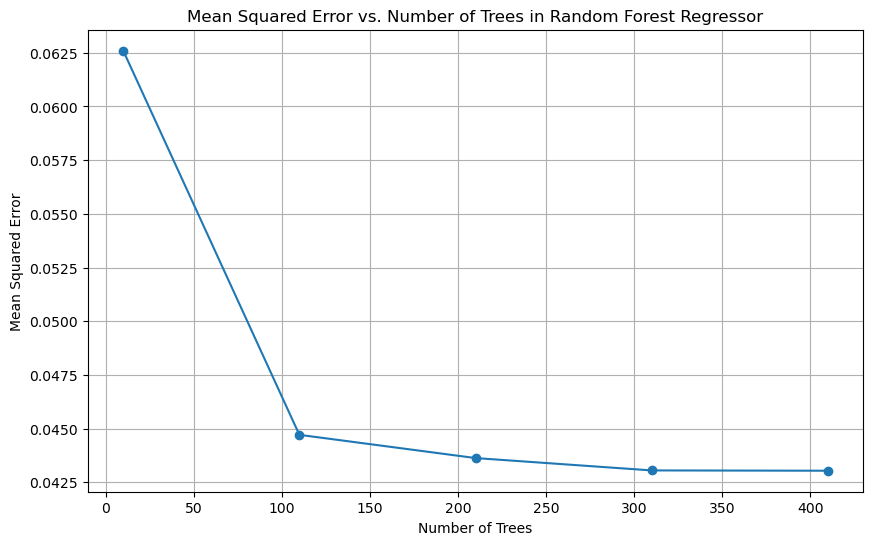

Optimal number of trees: 410


In [26]:
# training models with different no of trees
# List of different number of trees to try 
num_trees = list(range(10, 501, 100))
mse_scores = []

# Train a Random Forest Regressor model for each number of trees and calculate the mean squared error
for n in num_trees:
    rf_regressor = RandomForestRegressor(n_estimators=n, random_state=42)
    rf_regressor.fit(X_scaled, y)
    y_pred = rf_regressor.predict(X_scaled)
    mse_scores.append(mean_squared_error(y, y_pred))

    # plot accuracy vs number of trees
plt.figure(figsize=(10, 6))
plt.plot(num_trees, mse_scores, marker='o')
plt.title("Mean Squared Error vs. Number of Trees in Random Forest Regressor")  
plt.xlabel("Number of Trees")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

#print the optimal number of trees
# Find the optimal number of trees
optimal_trees = num_trees[np.argmin(mse_scores)]
print(f"Optimal number of trees: {optimal_trees}")

In [27]:
# final random forest regressor model
# Train the final Random Forest Regressor model with the optimal number of trees
final_rf_regressor = RandomForestRegressor(n_estimators=optimal_trees, random_state=42)
final_rf_regressor.fit(X_scaled, y)

# Evaluate the final model
y_pred = final_rf_regressor.predict(X_scaled)
final_mse = mean_squared_error(y, y_pred)
final_r2 = r2_score(y, y_pred)

print(f"Final Model Mean Squared Error: {final_mse:.6f}")
print(f"Final Model R^2 Score: {final_r2:.6f}")

#use other metrics
# Calculate the mean absolute error
final_mae = mean_absolute_error(y, y_pred)
print(f"Final Model Mean Absolute Error: {final_mae:.6f}")

Final Model Mean Squared Error: 0.043037
Final Model R^2 Score: 0.933968
Final Model Mean Absolute Error: 0.146663


##### PART 4.4

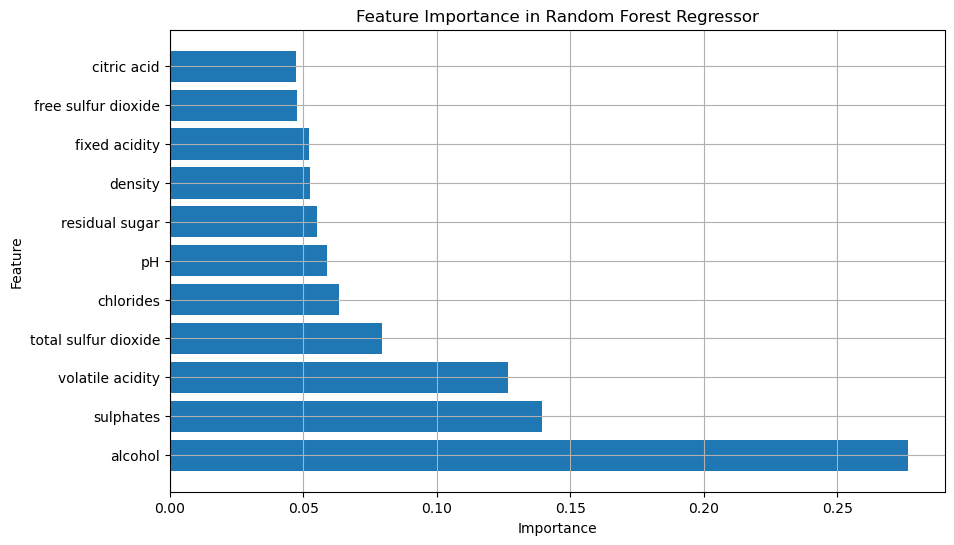

In [28]:
#get feature importance and remove quality from the features
# Get feature importances
feature_importances = final_rf_regressor.feature_importances_

# Create a DataFrame to store the feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame in descending order of the feature importances
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title("Feature Importance in Random Forest Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid()
plt.show()



##### PART 4.5

In [29]:
# recall the final random forest regressor model metrics
print(f"Final Model Mean Squared Error: {final_mse:.6f}")
print(f"Final Model R^2 Score: {final_r2:.6f}")
print(f"Final Model Mean Absolute Error: {final_mae:.6f}")


# train the linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_scaled, y)

#calculate the mean squared erroe, r2 score and mean absolute error
y_pred = linear_reg.predict(X_scaled)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"Linear Regression Model Mean Squared Error: {mse:.6f}")
print(f"Linear Regression Model R^2 Score: {r2:.6f}")
print(f"Linear Regression Model Mean Absolute Error: {mae:.6f}")

# train the knn model
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_scaled, y)

#calculate the mean squared erroe, r2 score and mean absolute error
y_pred = knn_reg.predict(X_scaled)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)

print(f"K-Nearest Neighbors Model Mean Squared Error: {mse:.6f}")
print(f"K-Nearest Neighbors Model R^2 Score: {r2:.6f}")
print(f"K-Nearest Neighbors Model Mean Absolute Error: {mae:.6f}")

# determine the best model based on mse
# Create a dictionary to store the evaluation metrics for each model
evaluation_metrics = {
    'Model': ['Random Forest Regressor', 'Linear Regression', 'K-Nearest Neighbors'],
    'Mean Squared Error': [],
    'R^2 Score': [],
    'Mean Absolute Error': []
}

# determine the best model based on mse and print it
# List of predictions for each model
predictions = [final_rf_regressor.predict(X_scaled), linear_reg.predict(X_scaled), knn_reg.predict(X_scaled)]

# Calculate evaluation metrics for each model
for y_pred in predictions:
    evaluation_metrics['Mean Squared Error'].append(mean_squared_error(y, y_pred))
    evaluation_metrics['R^2 Score'].append(r2_score(y, y_pred))
    evaluation_metrics['Mean Absolute Error'].append(mean_absolute_error(y, y_pred))

# Convert the evaluation metrics dictionary to a DataFrame for better visualization
evaluation_df = pd.DataFrame(evaluation_metrics)

# Display the evaluation metrics
print(evaluation_df)

# Determine the best model based on Mean Squared Error
best_model_index = evaluation_df['Mean Squared Error'].idxmin()
best_model_name = evaluation_df.loc[best_model_index, 'Model']
print(f"The best model based on mse is: {best_model_name}")


Final Model Mean Squared Error: 0.043037
Final Model R^2 Score: 0.933968
Final Model Mean Absolute Error: 0.146663
Linear Regression Model Mean Squared Error: 0.416767
Linear Regression Model R^2 Score: 0.360552
Linear Regression Model Mean Absolute Error: 0.500490
K-Nearest Neighbors Model Mean Squared Error: 0.290657
K-Nearest Neighbors Model R^2 Score: 0.554044
K-Nearest Neighbors Model Mean Absolute Error: 0.392120
                     Model  Mean Squared Error  R^2 Score  Mean Absolute Error
0  Random Forest Regressor            0.043037   0.933968             0.146663
1        Linear Regression            0.416767   0.360552             0.500490
2      K-Nearest Neighbors            0.290657   0.554044             0.392120
The best model based on mse is: Random Forest Regressor
